In [1]:
%load_ext autoreload
%autoreload 2

from agents import banditagents
from environments import bandits

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid", palette="pastel")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
num_initial_rounds = [10,20,40,60,120,240]
observe_simultaenously = [True, False]
observe_current_iteration = [True, False]
payoffs = [[x,round(1.0-x,1)] for x in [0.9, 0.8, 0.7, 0.6]]

In [5]:
bandit_config = {}
bandit_config['payoffs'] = [0.6, 0.4]
bandit_config['sampling_distribution'] = 'uniform'

demonstrator_config = {}
demonstrator_config['num_iterations'] = 300 #160
demonstrator_config['num_initial_iterations'] = 120
demonstrator_config['solver'] = 'greedy'
demonstrator_config['random_agent'] = False
demonstrator_config['social_agent'] = False

learner_config = {}
learner_config['num_iterations'] = demonstrator_config['num_iterations']
learner_config['num_initial_iterations'] = demonstrator_config['num_initial_iterations']
learner_config['solver'] = demonstrator_config['solver'] 
learner_config['random_agent'] = demonstrator_config['random_agent']
learner_config['social_agent'] = True
learner_config['observe_simultaneously'] = True
learner_config['observe_action_only'] = True
learner_config['observe_current_iteration'] = True

num_episodes = 1000
solvers = ['greedy']
env = bandits.Bandit(bandit_config)


demonstrator_all_rewards = np.empty(shape=(len(solvers),num_episodes, demonstrator_config['num_iterations']),dtype=float)
demonstrator_all_actions = np.empty(shape=(len(solvers),num_episodes, demonstrator_config['num_iterations']),dtype=float)
demonstrator_best_arm_estimate_proportions = np.zeros(env.num_arms)

learner_all_rewards = np.empty(shape=(len(solvers),num_episodes, learner_config['num_iterations']),dtype=float)
learner_all_actions = np.empty(shape=(len(solvers),num_episodes, learner_config['num_iterations']),dtype=float)
learner_best_arm_estimate_proportions = np.zeros(env.num_arms)

for i, solver in enumerate(solvers):
    for j in range(num_episodes):
        demonstrator = banditagents.GreedyAgent(demonstrator_config)
        # run greedy explore
        demonstrator(env)
        demonstrator_all_rewards[i,j,:] = demonstrator.reward_history
        demonstrator_all_actions[i,j,:] = demonstrator.arm_id_history


        learner = banditagents.GreedyAgent(learner_config)
        # run greedy explore
        learner(env, demonstrator)
        learner_all_rewards[i,j,:] = learner.reward_history
        learner_all_actions[i,j,:] = learner.arm_id_history
        
        demonstrator_best_arm_estimate_proportions[demonstrator.best_arm_id]+=1
        learner_best_arm_estimate_proportions[learner.best_arm_id]+=1
        
demonstrator_best_arm_estimate_proportions = demonstrator_best_arm_estimate_proportions/np.sum(demonstrator_best_arm_estimate_proportions)
learner_best_arm_estimate_proportions = learner_best_arm_estimate_proportions/np.sum(learner_best_arm_estimate_proportions)

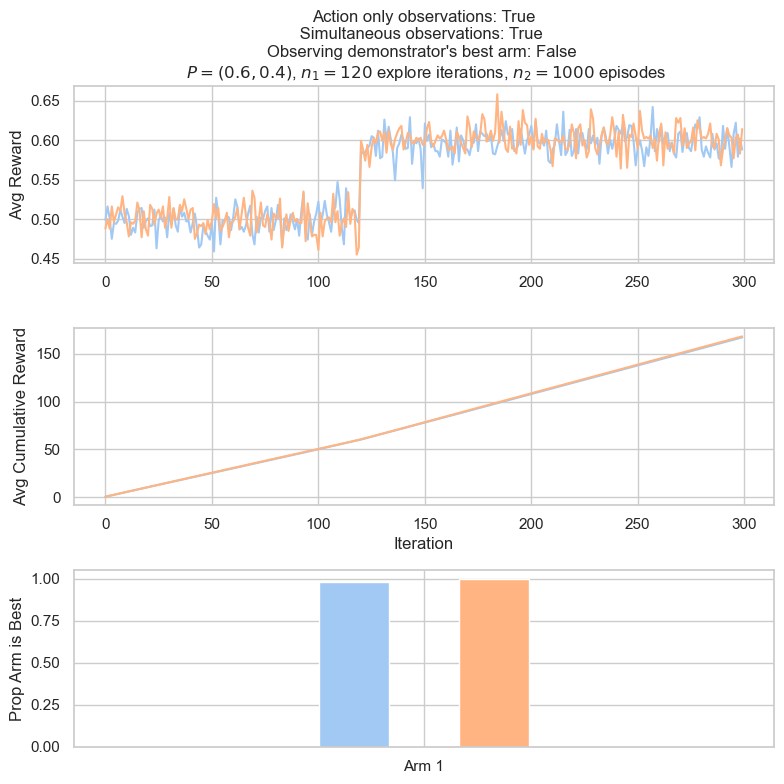

In [2]:
demonstrator_mean_reward_per_iteration = np.mean(demonstrator_all_rewards, axis=1)
demonstrator_sd_reward_per_iteration = np.mean(demonstrator_all_rewards, axis=1)
demonstrator_mean_cumulative_reward = np.cumsum(demonstrator_mean_reward_per_iteration,axis=1)
demonstrator_mean_cumulative_reward_after_exploration = np.cumsum(demonstrator_mean_reward_per_iteration[:,demonstrator_config['num_initial_rounds']:],axis=1)

learner_mean_reward_per_iteration = np.mean(learner_all_rewards, axis=1)
learner_sd_reward_per_iteration = np.mean(learner_all_rewards, axis=1)
learner_mean_cumulative_reward = np.cumsum(learner_mean_reward_per_iteration,axis=1)
learner_mean_cumulative_reward_after_exploration = np.cumsum(learner_mean_reward_per_iteration[:,demonstrator_config['num_initial_rounds']:],axis=1)

fig, axes = plt.subplots(nrows=3,ncols=1, figsize=(8,8), sharex=False, sharey='row')

for i, solver in enumerate(solvers):
    axes[0].plot(demonstrator_mean_reward_per_iteration[i], label='demonstrator')
    axes[0].plot(learner_mean_reward_per_iteration[i], label='learner')
    
    axes[1].plot(demonstrator_mean_cumulative_reward[i], label='demonstrator')
    axes[1].plot(learner_mean_cumulative_reward[i], label='learner')
    
    #axes[2,0].plot(demonstrator_mean_cumulative_reward_after_exploration[i], label='demonstrator')
    #axes[2,0].plot(learner_mean_cumulative_reward_after_exploration[i], label='learner')

    width = 0.2       
    axes[2].bar(1-width, demonstrator_best_arm_estimate_proportions[0], width, label='demonstrator')
    axes[2].bar(1 + width, learner_best_arm_estimate_proportions[0], width, label='learner')
    axes[2].set_xlim([0,2])
    axes[2].set_xticks([1])
    axes[2].set_xticklabels(['Arm 1'])
    
    
axes[0].set_ylabel('Avg Reward')
axes[1].set_ylabel('Avg Cumulative Reward')
#axes[2,0].set_ylabel('Avg Cumulative Reward After Exp')
axes[2].set_ylabel('Prop Arm is Best')

axes[1].set_xlabel('Iteration')
axes[1].set_xlabel('Iteration')
axes[0].set_title("Action only observations: {}\n Simultaneous observations: {}  \nObserving demonstrator's best arm: {} \n $P=({},{})$, $n_1={}$ explore iterations, $n_2={}$ episodes".format(
    learner_config['observe_action_only'],
    learner_config['observe_simultaneously'],
    not learner_config['observe_current_iteration'],
    bandit_config['payoffs'][0], 
    bandit_config['payoffs'][1],
    demonstrator_config['num_initial_rounds'], 
    num_episodes, 
    ))
#axes[0].set_title('Case 2')
#axes[0].legend()
#handles, labels = axes[1,0].get_legend_handles_labels()
#fig.legend(handles, labels, loc='upper left')
plt.tight_layout()
plt.show()

In [3]:
# finding: if learner only observed demsontrator choose its best arms and has poor estimates of other arms may incorrectly choose suboptimal arm
    # this is because with less samples you may over estimate a bad arm (always get reward of 1)
    # and because unless the optimal arm's prob is 1, then payoff estimate will be less than 1
    # so it is helpful to either explore on your own for the purposes of estimating other payoffs better 
    # or observe the demonstrator explore (but the more expert they are the less likely this will happen)

# thought: strategy could be - learner assumes demonstrator is better at the task - and purposely observes actions different from it (easy to do in best arm case)

# how much do we sample agent2? (treat as another arm or sample half the time?)

# Notes;
#1. summed improvement over demonstrator try different measures: reward/proportion of time : expected increase of reward over lifetime
#2. better solvers
#3. document with 3-7 closest works list (bbuilding on/responding to) - See Mark 
# - both cog/ai

# try different learners
1. observe simultaneously
2. observe as choice 
3. observe action only 
4. observe action and reward
5. change arm probabilities
6. what to observe - best action or current action
7. try two agents learning together

# visualizations
1. distribution of time choosing each arm (only need n-1 arms)
2. distribution of samples for each arm!! might be useful to know before/seperate/together

# for tomorrow: 
1. psudo code on mardown
2. explanation of how it works
3. what I ran
4. outcomes/plots - different cases
5. other findings
6. next steps?


In [8]:
bandit_config = {}
bandit_config['payoffs'] = [0.6, 0.4]
bandit_config['sampling_distribution'] = 'uniform'

demonstrator_config = {}
demonstrator_config['num_iterations'] = 300 #160
demonstrator_config['num_initial_rounds'] = 120
demonstrator_config['decay'] = None
demonstrator_config['epsilon'] = None
demonstrator_config['optimistic'] = None
demonstrator_config['solver'] = 'greedy'
demonstrator_config['random_agent'] = False
demonstrator_config['social_agent'] = False

learner_config = {}
learner_config['num_iterations'] = demonstrator_config['num_iterations']
learner_config['num_initial_rounds'] = demonstrator_config['num_initial_rounds']
learner_config['decay'] = demonstrator_config['decay']
learner_config['epsilon'] = demonstrator_config['epsilon']
learner_config['optimistic'] = demonstrator_config['optimistic']
learner_config['solver'] = demonstrator_config['solver'] 
learner_config['random_agent'] = demonstrator_config['random_agent']
learner_config['social_agent'] = True
learner_config['observe_simultaneously'] = True
learner_config['observe_action_only'] = True
learner_config['observe_current_iteration'] = True

num_episodes = 1000
solvers = ['greedy']
env = bandits.Bandit(bandit_config)
num_initial_rounds = [10,20,40,60]
cases = [[True, True], [True, False], [False, True], [False, False]]

demonstrator_arm1_best_arm_proportions = np.empty(shape=(len(cases),len(num_initial_rounds)))
learner_arm1_best_arm_proportions = np.empty(shape=(len(cases),len(num_initial_rounds)))


for c, (observe_simultaenously, observe_current_iteration) in enumerate(cases):
    learner_config['observe_simultaneously'] = observe_simultaenously
    learner_config['observe_current_iteration'] = observe_current_iteration
    
    for r, num_init_iter in enumerate(num_initial_rounds):
        #print(num_init_iter)
        demonstrator_config['num_initial_rounds'] = num_init_iter
        learner_config['num_initial_rounds'] = num_init_iter

        demonstrator_all_rewards = np.empty(shape=(len(solvers),num_episodes, demonstrator_config['num_iterations']),dtype=float)
        demonstrator_all_actions = np.empty(shape=(len(solvers),num_episodes, demonstrator_config['num_iterations']),dtype=float)
        demonstrator_best_arm_estimate_proportions = np.zeros(env.num_arms)

        learner_all_rewards = np.empty(shape=(len(solvers), num_episodes, learner_config['num_iterations']),dtype=float)
        learner_all_actions = np.empty(shape=(len(solvers), num_episodes, learner_config['num_iterations']),dtype=float)
        learner_best_arm_estimate_proportions = np.zeros(env.num_arms)

        for i, solver in enumerate(solvers):
            for j in range(num_episodes):
                #print('observe_simultaenously:', observe_simultaenously)
                #print('observe_current_iteration:', observe_current_iteration)
                demonstrator = banditagents.GreedyAgent(demonstrator_config)
                # run greedy explore
                demonstrator(env)
                assert(demonstrator.best_arm_id is not None), "({},{}), num_init_iter: {}, best_arm_id:{}".format(observe_simultaenously, observe_current_iteration, num_init_iter, demonstrator.best_arm_id)
                demonstrator_all_rewards[i,j,:] = demonstrator.reward_history
                demonstrator_all_actions[i,j,:] = demonstrator.arm_id_history
                
                

                learner = banditagents.GreedyAgent(learner_config)
                # run greedy explore
                learner(env, demonstrator)
                assert(learner.best_arm_id is not None), "({},{}), num_init_iter: {}, best_arm_id:{}".format(observe_simultaenously, observe_current_iteration, num_init_iter, learner.best_arm_id)
                learner_all_rewards[i,j,:] = learner.reward_history
                learner_all_actions[i,j,:] = learner.arm_id_history
                
                demonstrator_best_arm_estimate_proportions[demonstrator.best_arm_id]+=1
                learner_best_arm_estimate_proportions[learner.best_arm_id]+=1
                
        demonstrator_best_arm_estimate_proportions = demonstrator_best_arm_estimate_proportions/np.sum(demonstrator_best_arm_estimate_proportions)
        learner_best_arm_estimate_proportions = learner_best_arm_estimate_proportions/np.sum(learner_best_arm_estimate_proportions)
        
        demonstrator_arm1_best_arm_proportions[c,r] = demonstrator_best_arm_estimate_proportions[0]
        learner_arm1_best_arm_proportions[c,r] = learner_best_arm_estimate_proportions[0]



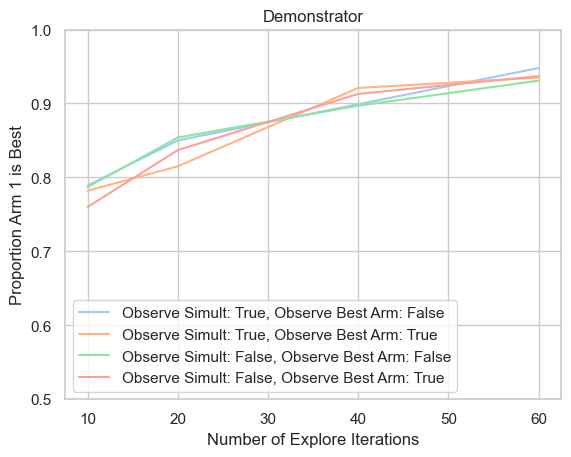

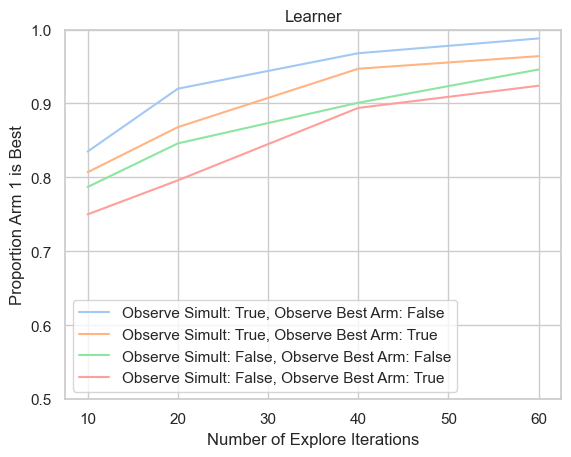

In [36]:
for c, case in enumerate(cases):
    plt.plot(np.array(num_initial_rounds), demonstrator_arm1_best_arm_proportions[c,:], label = 'Observe Simult: {}, Observe Best Arm: {}'.format(case[0], not case[1]))
plt.legend()
plt.title('Demonstrator')
plt.xlabel('Number of Explore Iterations')
plt.ylabel('Proportion Arm 1 is Best')
plt.ylim([0.5,1])
plt.show()

for c, case in enumerate(cases):
    plt.plot(np.array(num_initial_rounds), learner_arm1_best_arm_proportions[c,:], label = 'Observe Simult: {}, Observe Best Arm: {}'.format(case[0], not case[1]))
plt.legend()
plt.title('Learner')
plt.xlabel('Number of Explore Iterations')
plt.ylabel('Proportion Arm 1 is Best')
plt.ylim([0.5,1])
plt.show()




In [1]:
import numpy as np

In [16]:
_, counts = np.unique([0,0,1,2,3,4,4,4,4,5,6,4], return_counts=True)

In [20]:
np.argmax(np.bincount([0,0,1,2,3,4,4,4,4,5,6,4]))

4

In [9]:
arm_ids = [0,1,2]
num_arms = len(arm_ids)
alphas, betas = {arm_id:1 for arm_id in arm_ids}, {arm_id:1 for arm_id in arm_ids}


chosen_arm_id = np.argmax([np.random.beta(alphas[arm_id], betas[arm_id]) for arm_id in num_arms])

TypeError: 'int' object is not iterable

In [10]:
[np.random.beta(alphas[arm_id], betas[arm_id]) for arm_id in num_arms]

TypeError: 'int' object is not iterable

In [11]:
np.random.beta(alphas[arm_id], betas[arm_id])

NameError: name 'arm_id' is not defined

In [13]:
[print(arm_id) for arm_id in range(num_arms)]

0
1
2


[None, None, None]

In [22]:
'Thompson' in 'TrustingThompson'

False

In [ ]:
for learnerAgentSolver in nonsocial_solvers: 
    if 

In [23]:
TrustSolvers = ['TrustThompson']
NonTrustSolvers = ['Thompson']

solver = 'TrustThompson'
if solver in TrustSolvers:
    learnerSolver = solver
    for nontrustsolver in NonTrustSolvers:
        if nontrustsolver in learnerSolver:
            demonstratorSolver = nontrustsolver

In [24]:
learnerSolver

'TrustThompson'

In [25]:
demonstratorSolver

'Thompson'

In [26]:
TrustSolvers = ['ThompsonTrust']
NonTrustSolvers = [solver[:-5] for solver in TrustSolvers]

In [27]:
NonTrustSolvers

['Thompson']

In [29]:
type(np.random.sample())

float

In [48]:

nums

array([[0],
       [1],
       [1],
       [1]])

In [52]:

for i in range(10):   
    nums = np.random.choice([0, 1, 2], size=(4), p=[.1, .85, 0.05]).reshape(4,1)
    if i == 0:
        all_episodes_arm_id_history = np.array()
    else:
        all_episodes_arm_id_history = np.hstack((all_episodes_arm_id_history, nums))
    print(all_episodes_arm_id_history)

    # propertion of time best arm is chosen
    prop_best_arm = np.mean(all_episodes_arm_id_history == 0,axis=1)
    # proportion of time observe is chosen
    prop_observe = np.mean(all_episodes_arm_id_history == 2,axis=1)
    # proportion of time alternative arm is chosen
    1 - prop_best_arm - prop_observe

    print(prop_best_arm)



[[1]
 [1]
 [1]
 [0]]
[0. 0. 0. 1.]
[[1 0]
 [1 1]
 [1 1]
 [0 2]]
[0.5 0.  0.  0.5]
[[1 0 1]
 [1 1 1]
 [1 1 0]
 [0 2 1]]
[0.33333333 0.         0.33333333 0.33333333]
[[1 0 1 1]
 [1 1 1 1]
 [1 1 0 1]
 [0 2 1 1]]
[0.25 0.   0.25 0.25]
[[1 0 1 1 1]
 [1 1 1 1 1]
 [1 1 0 1 1]
 [0 2 1 1 1]]
[0.2 0.  0.2 0.2]
[[1 0 1 1 1 1]
 [1 1 1 1 1 1]
 [1 1 0 1 1 1]
 [0 2 1 1 1 1]]
[0.16666667 0.         0.16666667 0.16666667]
[[1 0 1 1 1 1 1]
 [1 1 1 1 1 1 1]
 [1 1 0 1 1 1 1]
 [0 2 1 1 1 1 2]]
[0.14285714 0.         0.14285714 0.14285714]
[[1 0 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]
 [1 1 0 1 1 1 1 1]
 [0 2 1 1 1 1 2 1]]
[0.125 0.    0.125 0.125]
[[1 0 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1]
 [1 1 0 1 1 1 1 1 1]
 [0 2 1 1 1 1 2 1 1]]
[0.11111111 0.         0.11111111 0.11111111]
[[1 0 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]
 [1 1 0 1 1 1 1 1 1 1]
 [0 2 1 1 1 1 2 1 1 1]]
[0.1 0.  0.1 0.1]


In [38]:
np.mean(nums != 0 or nums != 2,axis=1) 

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [42]:
(nums != 0) 

array([[ True,  True,  True],
       [False,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True]])

In [53]:
prop_best_arm.shape

(4,)